#  Functional Connectivity Trial-by-Trial Classifier
### Given the functional connectivity of a subject during a specific trial, can we predict the Subject's trial accuracy? 
Here we extract ROI timeseries as from each time window that encapsualtes the fMRI bold data from a specific trial. For a full set of test runs, this should yield 48 ROI Timeseries of varying length (dependent on how long each trial took to complete). For each ROI Timeseries we compute a functional connectivity matrix, called a 'connectome' using various kinds of funcitonal connectivity metrics. We then feed the Trial-by-Trial Connectomes and their respective trial accuracy labels (0 for incorrect or 1 for correct) into a Support Vector Machine Classifier with a linear kernel. We hold out some of the data for cross validation and test this model over several randomized cross-validation splits. We test the model classifier for each functional connectivity metric for each cross-validation split, and plot their average performance.

## Load Dependencies

In [11]:
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import nibabel as nib
import numpy as np
import pandas
import os
import glob
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from nilearn import plotting
from matplotlib import pyplot as plt
from nilearn import input_data
import pickle

## Define 'Helper' Functions
The following functions are used to help with preprocessing the Functional Bold data into the Time-Windowed ROI Timeseries with respective accuracy labels. This serves as the model's X and Y values, respectively.

### Create Trial Labels
From behavioral data, create a pandas data frame containing accuracy labels and respective run names (1-6)

In [12]:
def create_trial_labels(subjectnum, sync_pulses, test_trials):
    # Filter by subject
    test_labels = test_trials[test_trials['Subject'] == subjectnum].copy()
    
    # Initialize Pandas data series for Start and End TRs, as well as for fmri_run number
    start_TR = pandas.Series(dtype = 'float32')
    end_TR = pandas.Series(dtype = 'float32')
    fmri_run = pandas.Series(dtype = 'float32')
    
    # Get order of task type for labeling wich fmri run each entry corresponds too
    time_indices = np.unique(test_labels['times'], return_index = True)[1]
    task_order = []
    [task_order.append(test_labels.iloc[[i]]['Task_type'].to_string().split()[1]) for i in time_indices]
    

    
    
    for i in sync_pulses.index:

        data = test_labels[test_labels['Task_type'] == sync_pulses.trial_type[i]].copy()

        trial_times = np.unique
        start_tr = np.floor((data["trial_starttime"].copy() - sync_pulses.getready_response[i]) / 720).astype(int)
        end_tr = np.floor((data["trial_endtime"].copy() - sync_pulses.getready_response[i]) / 720).astype(int)
        run_num = task_order.index(sync_pulses.trial_type[i])


        start_TR = pandas.concat([start_TR, pandas.Series(start_tr)])
        end_TR = pandas.concat([end_TR, pandas.Series(end_tr)])
        
        if run_num > 1:
            run_num = 'Run' + str(run_num - 1)
        elif run_num == 1:
            run_num = 'Ex2' 
        else:
            run_num = 'Ex'
        fmri_run = pandas.concat([fmri_run, pandas.Series([run_num] * len(end_tr))])
        
        
        
        
    test_labels = test_labels[['Subject', 'Task_type', 'trial_starttime', 'trial_endtime', 'accuracy']]
    
    test_labels['start_TR'] = start_TR.values
    test_labels['end_TR'] = end_TR.values
    test_labels['fmri_run'] = fmri_run.values

    
    return test_labels, task_order

### Extract ROI Timeseries
Given a funcitonal scan and atlas ROI map, extract bold signal into ROI time series. Smooth and standardize the signal.

In [13]:
def subject_timeseries(mlindiv_filename, confounds_filename, atlas_filename):
    
    # Load fmri volumes
    func_img = nib.load(mlindiv_filename)
    header_zooms = func_img.header.get_zooms()
    TR = header_zooms[3]

    pandas.read_csv(confounds_filename, sep = '\t').fillna(0).to_csv("conf_nona_temp.tsv", sep = '\t', index = False)

    print('Atlas ROIs are located in nifti image (4D) at: %s' % atlas_filename)
    print('Func images are located in nifti image (4D) at: %s \n\t--- Confounds at: %s' % (mlindiv_filename, confounds_filename))
    print('Func images Voxel Dimensions (mm): %s\tFunc TR: %s' % (header_zooms[0:3], header_zooms[3]))

    # Create a masker from the HO atlas
    masker = input_data.NiftiMapsMasker(
        atlas_filename, 
        resampling_target='data',
        memory = 'nilearn_cache', 
        verbose = 0, low_pass=0.1, high_pass=0.01, detrend=True, t_r = TR).fit()


    # Create an overall time series for the run
    time_series = masker.transform(mlindiv_filename, confounds = 'conf_nona_temp.tsv')
    
    return time_series


### Create Trial-by-Trial ROI Timeseries
Given an ROI Timeseries from a signle scan, bin timeseries into timewindows bounded by the begin and end trial times for each trial during that scan run. Thus, we take an ROI time series from a signle run and split it into 8 separate ROI time series corresponding to the 8 individual trials for that scan run.


In [14]:
def timewindows(timeseries, trial_labels, task_label, start_padding = 0, end_padding = 0):
    t_labels = trial_labels[trial_labels['Task_type'] == task_label]
    
    time_window_num = t_labels.shape[0]

    
    time_windows = []

    for i in range(time_window_num):
        
        start_TR = t_labels.start_TR.iloc[i] + start_padding
        end_TR = t_labels.end_TR.iloc[i] + end_padding
        
        time_window = timeseries[start_TR:end_TR, :]
        time_windows.append(time_window)
        
    return time_windows

### Aggregate Trial-by-Trial ROI Timeseries
For each scan run, use the previously defined functions to aggregate all Trial-by-Trial ROI Timeseries into one dictionary where each key is the Task label / Scan of Origin (i.e. 'A2' or 'C5') and its values are a list of that scan's Trial-by-Trial ROI Timeseries.

In [15]:
def aggregate_timewindows(subject, func_directory, confounds_directory, trial_labels, atlas_filename, start_padding = 7, end_padding = 7):
    
    # Define list of files to be processed, given subject number and location of functional files.
    directory_path = "%s/sub-%s" % (func_directory, subject)
    trial_filenames = os.listdir(directory_path)
    print("Functional Images for Subject %s stored in %s" % (subject, directory_path))
    print("Functional files to be processed: " + str(trial_filenames))
    
    # Initialize empty Dictionary of Windowed - Time Series
    dict_timewindows = {}
    
    for run in trial_filenames:
        # Grab task label from matching the func run number to trial labels.
        run_name = run.split("bold")[1].split("_")[0]
        task_label = np.unique(trial_labels[trial_labels['fmri_run'] == run_name].Task_type)[0]
        print("Computing ROI Time Series for %s: %s" % (run_name, task_label))
        
        # Get path to func file and corresponding confounds file
        mlindiv_filename = directory_path+ '/' + run
        confounds_filename = glob.glob("%s/*%s*%s_*.tsv" % (confounds_directory, subject, run_name))[0]
        
        # Compute time series for func run
        time_series = subject_timeseries(mlindiv_filename, confounds_filename, atlas_filename)
        
        # Split time series into list time windows
        time_windows = timewindows(time_series, trial_labels, task_label, start_padding, end_padding)
        
        # For current Run, assign the list of time windows obtained from the previous line
        dict_timewindows[task_label] = time_windows
    
    return dict_timewindows

### Model the SVM Classifier
Using the trial-by-trial ROI timeseries, compute their functional connectomes and fit the trial accuracy for each trial to its connectome. This is done over several cross-validation splits and using different kinds of functional connectivity measures to fit the model. If plot_scores is set to True, plot the average performance for each model (by functional connectivity measure used). The default functional connectivity measures to use are: 
- Correlation
- Partial Correlation
- Tangent
- Covariance
- Precision

In [16]:
def model_connectome(ts_list, ts_labels, subject_set, C = 1, n_splits = 10, fconn_types = ['correlation', 'partial correlation', 'tangent', 'covariance', 'precision'], plot_scores = True):
    # If ts_list | ts_labels are a dictionary, collapse them into a list
    if type(ts_labels) == dict:
        ts_labels = {k: ts_labels[k] for k in ts_labels.keys() & subject_set}
        ts_list = {k: ts_list[k] for k in ts_list.keys() & subject_set}
        ts_labels = [item for sublist in list(ts_labels.values()) for item in sublist]
        ts_list = [item for sublist in list(ts_list.values()) for item in sublist]
        
    # Define and run the Model
    _, classes = np.unique(ts_labels, return_inverse=True)  # Convert accuracy into numpy array of binary labels
    ts_array = np.asarray(ts_list) # Convert list of time series into a numpy array of time series

    # Define correlation types
    kinds = fconn_types
    _, classes = np.unique(ts_labels, return_inverse=True)
    cv = StratifiedShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.3)
    ts_array = np.asarray(ts_list)

    scores = {}

    for kind in kinds:
        scores[kind] = []
        for train, test in cv.split(ts_array, classes):
            connectivity = ConnectivityMeasure(kind = kind, vectorize = True) # We vectorize the Functional Connectivity, so it is easier to run the SVC classifier on
            connectomes = connectivity.fit_transform(ts_array[train])

            classifier = LinearSVC(C = C).fit(connectomes, classes[train])
            predictions = classifier.predict(connectivity.transform(ts_array[test]))
            scores[kind].append(accuracy_score(classes[test], predictions)) 
    
    if plot_scores:
        chance_level = np.mean(ts_labels)
        print('CHANCE: ', chance_level)
        mean_scores = [np.mean(scores[kind]) for kind in kinds]
        print('MEAN MODEL ACC: ', mean_scores)
        scores_std = [np.std(scores[kind]) for kind in kinds]
    
        plt.figure(figsize=(6, 4))
        positions = np.arange(len(kinds)) * .1 + .1
        plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
        yticks = [k.replace(' ', '\n') for k in kinds]
        plt.yticks(positions, yticks)
        plt.gca().grid(True)
        plt.gca().set_axisbelow(True)
        plt.gca().axvline(chance_level, color='red', linestyle='--')
        plt.xlabel('Classification accuracy\n(red line = chance level)')
        plt.tight_layout()

    return(scores)

### Create Dictionary of Subjects and their Trial-by-Trial ROI Timeseries with Accuracy Labels
Using the helper functions defined above, for any given list of subjects and the correct directories for reading in certain files:
- create a dictionary of subjects as keys with ROI Timeseries as values 
- create a dictionary of subjects as keys with accuracy labels as values

In [29]:
def subject_timeseries_labels(sub_num_list, behav_directory, func_directory, confounds_directory, sync_pulses_directory, atlas_filename):
    '''
    This function takes a list of subject numbers and runs through several helper functions iterating over each subject
    to output a dictionary of subject - timeseries pairs (X) and a dictionary of subject - labels pairs (Y) to be run through any model.
        Requirements:
            - A behavioral directory containing the trial master.csv
            - a func directory pointing to the functional files to be used. Make sure there are no duplicate runs
            - a confoudns directory contianing only conformatted .tsv files (refer to R script conformat)
            - a directory containing syncpulse.csv files for each subject
    It takes roughly 45 secs to extract and properly label each ROI time series per Test Scan. So for scans looking at 6 runs it can take a little under 4 min to fully run. 
    It does store extractions in a cache, however, so when rerun using previously run subjects it should be a lot quicker.
    '''
    # Read in trial data
    test_trials = pandas.read_csv('%s/MLINDIV_trial_master.csv' % behav_directory)
    
    subject_timeseries = {}
    subject_labels = {}
    errored_subjects = {}
    
    # Loop through each subject's and create ROI timeseries for each trial
    for sub_num in sub_num_list:
        try:
            # Read in the sync_pulse start time data
            sync_pulses = pandas.read_csv('%s/sub-%s_syncpulses.csv' % (sync_pulses_directory, sub_num))

            # Create trial labels for the subject, using the sync pulse trial start time info
            trial_labels, _ = create_trial_labels(int(sub_num), sync_pulses, test_trials)

            # Extract ROI time series into a trial dictionary (keys = Run name, values = list of ROI time series for that run) for each trial timewindow defined by the trial labels
            sub_TW = aggregate_timewindows(sub_num, func_directory, confounds_directory, trial_labels, atlas_filename)

            ts_list = []
            ts_labels = []

            # Iterate through Subject's Trial dictionary, creating a List of timeseries (ts_list) and a list of accuracy labels for those timeseries irrespective of run type
            for tasktype in sub_TW.keys():
                if not tasktype.isnumeric():      
                    acc = list(trial_labels[trial_labels['Task_type'] == tasktype]['accuracy'])
                    [ts_labels.append(value) for value in acc]
                    for ts in sub_TW[tasktype]:
                        ts_list.append(ts)   

            subject_timeseries[sub_num] = ts_list
            subject_labels[sub_num] = ts_labels
        except Exception as e:
            errored_subjects[sub_num] = e
    with open('X_small_msdl_taskfmri_CPM.pickle', 'wb') as handle:
        pickle.dump(subject_timeseries, handle, protocol = pickle.HIGHEST_PROTOCOL)

    with open('Y_small_msdl_taskfmri_CPM.pickle', 'wb') as y_handle:
        pickle.dump(subject_labels, y_handle, protocol = pickle.HIGHEST_PROTOCOL)
            
    print(errored_subjects)
    return subject_timeseries, subject_labels

        

### Create X and Y Dictionaries
First define what atlas to extract ROIs into. Then create dictionaries of extracted & binned ROI timeseries that will be fed into the SVM model. 

In [18]:
subs = ['014', '019', '020', '021', '024', '025', '027', '033', '043', '058',
                                                                  '028', '029', '031', '032', '034', '036', '037', '045', '046', 
                                                                   '049', '050', '060', '062', '065', '068', '069', '070',
                                                                   '071', '072', '074', '079', '081', '082', '083', '084', '085', '086', 
                                                                   '088', '089', '091', '093', '094', '095', '096', '098', '099', '100',
                                                                   '101', '102']
len(subs)

49

In [ ]:
'''
dataset = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels
'''
dataset = datasets.fetch_atlas_msdl()
atlas_filename = dataset.maps
msdl_coords = dataset.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, dataset.networks))

base_dir = "/mnt/chrastil/lab/users/rob/projects/MachineLearning"



sub_X_dict, sub_Y_dict = subject_timeseries_labels(sub_num_list = ['014', '019', '020', '021', '024', '025', '027', '033', '043', '058'], 
                                                   behav_directory = base_dir + '/behavioral',
                                                   func_directory = base_dir + '/func',
                                                   confounds_directory = base_dir + '/confounds',
                                                   sync_pulses_directory = base_dir + '/syncpulses',
                                                   atlas_filename = atlas_filename
                                                  )

In [46]:

with open('X_msdl_taskfmri_CPM.pickle', 'rb') as handle:
    sub_X_dict = pickle.load(handle)

with open('Y_msdl_taskfmri_CPM.pickle', 'rb') as y_handle:
    sub_Y_dict = pickle.load(y_handle)

In [47]:
sub_X_dict.keys()

dict_keys(['014', '019', '020', '021', '024', '025', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', '085', '086', '088', '089', '093', '094', '095', '096', '098', '099', '100', '101', '102'])

### Run the Model
Using the X and Y dictionaries, compute several iterations of the SVM model and store the scores for average model performance (for each functional connectivity measure used). Plot the scores if plot_scores is set to True (default).

Note: datacauses error for model for subjects: 019, 025

In [ ]:
error_dict = {}
good_subs = []
for subject in sub_X_dict.keys():
    try:
        model_connectome(sub_X_dict, sub_Y_dict, {subject}, C = 1, n_splits = 10, fconn_types = ['tangent']) 
    except Exception as e:
        error_dict[subject] = e
    else: 
        good_subs.append(subject)

In [76]:
print(good_subs)
error_dict

['014', '020', '021', '024', '027', '043', '058', '028', '029', '032', '036', '037', '045', '046', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '083', '084', '085', '086', '088', '089', '094', '095', '099', '100', '101']


{'019': ValueError('Expected a symmetric positive definite matrix.'),
 '025': ValueError('Expected a symmetric positive definite matrix.'),
 '033': ValueError('This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0'),
 '031': ValueError('The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.'),
 '034': ValueError('The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.'),
 '049': ValueError('The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.'),
 '082': ValueError('This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0'),
 '093': ValueError('Expected a symmetric positive definite matrix.'),
 '096': ValueError("Input contains NaN, infinity or a value too large f

TOTAL SUBJECTS:  42


/home/rwoodry/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/rwoodry/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/rwoodry/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/rwoodry/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations

CHANCE:  0.5845141700404858
MEAN MODEL ACC:  [0.7, 0.6693086003372681, 0.7399662731871838, 0.6602023608768972, 0.5851602023608768]


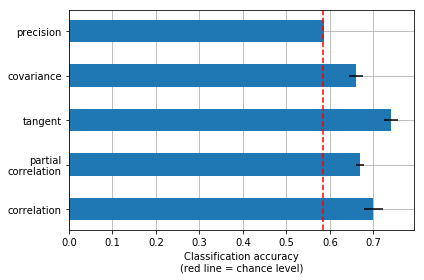

In [83]:
subjects = set(good_subs + ['033', '031', '034', '049', '082', '098'])
print("TOTAL SUBJECTS: ", len(subjects))
scores = model_connectome(sub_X_dict, sub_Y_dict, subjects, C = 0.005, n_splits = 10) 

/home/rwoodry/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/rwoodry/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/rwoodry/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/rwoodry/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations

CHANCE:  0.5845141700404858
MEAN MODEL ACC:  [0.693591905564924, 0.7035413153456999, 0.7347386172006745, 0.6585160202360878, 0.5851602023608768]


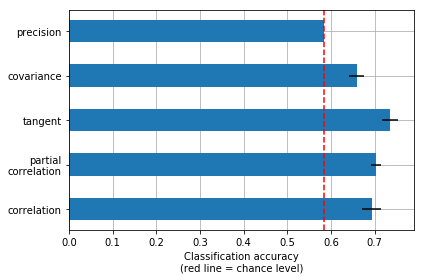

In [84]:
scores = model_connectome(sub_X_dict, sub_Y_dict, subjects, C = 0.01, n_splits = 10) 

In [33]:
scores.get_params()


{'C': 0.005,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

Above we see that even when training on a small number of trial connectomes (70% of 48 trials (rounded down) = 33 trials to train on), some models perform slightly better than chance. Will the model improve given more training data (using multiple subjects)? Some things that could improve the model:
   - More training trials (i.e. use more subjects)
   - Use a Cortical atlas & Subcortical Atlas for more ROIs across the whole brain
   - OR Use Dictionary Learning on MLINDIV subjects Resting State fMRI to build an experiment specific functional ROI Atlas
   - Binarize the connectomes according to some threshold (i.e. top 20% of conenctions). This might help the model learn faster as well as serve as some form of regularization, as it creates sparsity across features.
   - Test alternate time window sizes. Shift time windows 6+ TRs to capture HRF delay, or widen windows so that each time window is of the same duration centered at the midpoint of trial runtime.
   - Try different Model Classifiers: Logistic Regression, SVM with a Gaussian Kernel, etc.
   - MAYBE: Try Deep Learning Model architectures: Fully Connected Layers, Sequence to Sequence RNNs, Unidirectional LSTM, Bidirectional LSTM, A Combination of Several of these.

If Succesful:
- Move on to Regression Models to predict Subject Performance
- Use Dynamic Functional Connectivity
- Use DNNs, etc.